In [100]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input,optimizers, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float32'

In [2]:
# INIT
# PART 1
number_samples = [128, 256, 512, 1024, 4096] 
validation_size, noise_floor = 0.2, -110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 299, 299, 3, 60  # su_size:30 for 1000, 10 for 100
cell_size, pixel_expansion = 1000 / max_x, max_x / 100
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope, su_slope = 'log', 5, 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 20, 5
propagation_model = 'splat' # 'splat', 'log', 'testbed'
noise, std = False, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 225
    sensors_file_path = f"data/sensors/square{100}/{sensors_num}/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 12
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '_transfer/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (f"{intensity_degradation}_pu{slope}_su{su_slope}")) + (
    "/" + str(sensors_num) + "sensors" if sensors else f"/{max_pus_num}pus") + \
        f"_{max_sus_num}sus_{number_image_channels}channels" + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [ ]:
image_dir 

In [5]:
# image_dir = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/log/" +\
#             "noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/" +\
#             "variable_sensors_10_20_pus_5_sus_8_channels/images"
sensors_location = {}
for sensor_num in [49, 100, 225, 400, 625]:
    sensors_location[sensor_num] = []
    with open(f"data/sensors/square{100}/{sensor_num}/sensors.txt", 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location[sensor_num].append(Point(int(float(line[0])), int(float(line[1]))))

In [ ]:
plt.hist(data_reg[0:100:1, :100], bins='auto')

In [72]:
# LOAD DATA
MAX_SU_TOTAL = True
num_columns = (sensors_num + 1 if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
# num_columns = max_pus_num * 3 + 1 + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_50000_min10_max20PUs_5SUs_square100grid_splat_2022_06_09_13_24.txt"
max_dataset_name = "dynamic_pus_max_power_50000_min10_max20PUs_5SUs_square100grid_splat_2022_06_09_13_24.txt"
if MAX_SU_TOTAL:
    max_su_total_dataset_name = "dynamic_pus_maximum_total_sus50000_min10_max20PUs_5SUs_square100grid_splat_2022_06_09_13_24.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)
    if MAX_SU_TOTAL:
        set_file.write(max_su_total_dataset_name)

dataframe = pd.read_csv('data/' 
                        + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('data/' 
                            + max_dataset_name, delimiter=',', header=None)
if MAX_SU_TOTAL:
    dataframe_max_su_total = pd.read_csv('data/' + max_su_total_dataset_name, delimiter=",", header=None,
                                        names=[i for i in range(max_sus_num * 3 + 1)])

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)
if MAX_SU_TOTAL:
    dataframe_max_su_total.reset_index(drop=True, inplace=True)
dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)
if MAX_SU_TOTAL:
    dataframe_max_su_total.drop(idx, inplace=True)

data_reg = dataframe_tot.values
data_reg[data_reg < noise_floor] = noise_floor
if MAX_SU_TOTAL:
    data_max_su_tot = dataframe_max_su_total.values

if False and sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [27]:
data_reg[56,:]

array([225.   , -87.793, -84.376, -83.528, -81.822, -75.905, -66.582,
       -74.179, -73.021, -69.737, -57.872, -67.844, -70.076, -70.457,
       -73.44 , -77.393, -85.975, -82.953, -74.184, -79.187, -77.676,
       -76.026, -73.896, -73.696, -70.641, -65.995, -68.487, -69.938,
       -69.732, -69.752, -72.175, -86.43 , -83.924, -78.311, -77.882,
       -75.753, -72.736, -69.31 , -72.285, -71.614, -70.488, -65.709,
       -64.755, -64.035, -65.505, -70.898, -87.179, -85.966, -80.402,
       -80.979, -77.596, -72.971, -68.651, -72.127, -71.146, -68.837,
       -67.846, -64.873, -45.862, -66.383, -69.093, -87.078, -85.946,
       -84.992, -80.244, -79.394, -76.972, -76.694, -77.052, -70.44 ,
       -71.027, -68.209, -63.084, -62.659, -67.373, -67.48 , -87.243,
       -87.241, -86.551, -80.209, -78.736, -77.566, -74.604, -74.698,
       -71.771, -70.846, -67.554, -60.771, -60.797, -67.122, -67.29 ,
       -88.056, -84.096, -86.428, -85.156, -83.467, -81.174, -80.467,
       -78.297, -71.

In [ ]:
data_reg = data_reg[:30000][:]

In [8]:
data_reg = data_reg[:40000]

In [6]:
data_reg_train = data_reg[12000][:]

In [5]:
data_reg.shape

(32162, 79)

In [6]:
data_max_su_tot[2]

array([ 5.   , 30.   , 80.   , 12.773, 68.   , 91.   , 18.252, 66.   ,
       56.   ,  9.604, 30.   , 82.   , 10.786, 28.   ,  8.   , 11.592])

In [34]:
data_reg[0]

array([ 19.   ,  38.   ,  65.   , -19.658,  69.   ,  49.   ,  -7.351,
        88.   ,  42.   ,  -6.322,  28.   ,  17.   ,  -5.694,  61.   ,
        45.   , -17.43 ,   2.   ,  55.   , -24.392,  57.   ,  95.   ,
       -20.778,  52.   ,  79.   , -21.744,  52.   ,   5.   , -13.93 ,
         6.   ,  39.   ,  -6.269,  87.   ,   8.   , -21.177,  26.   ,
        80.   , -20.406,  19.   ,  63.   , -15.858,  30.   ,  19.   ,
       -13.793,  27.   ,  50.   , -17.062,  95.   ,  95.   , -29.368,
        39.   ,  71.   ,  -3.309,  52.   ,  59.   , -11.98 ,  38.   ,
        16.   , -22.553,   1.   ,  95.   ,  30.   ,  -7.839,   1.   ,
           nan,     nan,     nan,  11.077])

In [ ]:
np.max(data_reg[:, -1])

In [5]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5 * cell_size

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle',
                 pu_param=None, su_shape='circle', su_param=None, intensity_degradation="log", 
                 max_pu_power: float=0, max_su_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((max_x, max_y, number_image_channels), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
                pu_p = data[pu_i * 3 + 3]
                pu_channel = int(abs(pu_p)//5) if number_image_channels > 3 else 0
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y),
                                             shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[int(abs(pu_p))//10][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][pu_channel] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][pu_channel] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_channels_num = number_image_channels - 2
            ss_param, ss_shape = pu_param, pu_shape
            sensors_num = int(data[0])
            sensors_num_at_each_row = int(sensors_num ** 0.5)
            for ss_i in range(sensors_num):
                ss_x = max(0, min(max_x-1, int(sensors_location[sensors_num][ss_i].x * pixel_expansion)))
                ss_y =  max(0, min(max_x-1, int(sensors_location[sensors_num][ss_i].y * pixel_expansion)))
                ss_p = max(noise_floor, data[ss_i+1])
#                 ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x * pixel_expansion))), max(
#                     0, min(max_x-1, int(sensors_location[ss_i].y * pixel_expansion))), max(noise_floor, data[ss_i])
#                 ss_channel = 0 
# #                 if -62.5 <= ss_p < -50.0:
# #                     ss_channel = 1
# #                 elif -70.0 <= ss_p < -62.6:
# #                     ss_channel = 2
# #                 elif -77.5 <= ss_p < -70.0:
# #                     ss_channel = 3
# #                 elif -85.0 <= ss_p < -77.5:
# #                     ss_channel = 4
# # #                 elif -70.0 <= ss_p < -65.0:
# # #                     ss_channel = 5
# #                 elif ss_p < -85.0:
# #                     ss_channel = 5
#                 if -70 <= ss_p < -60.0:
#                     ss_channel = 1
#                 elif -80.0 <= ss_p < -70:
#                     ss_channel = 2
#                 elif -90.0 <= ss_p < -80.0:
#                     ss_channel = 3
#                 elif -100.0 <= ss_p < -90.0:
#                     ss_channel = 4
#                 elif ss_p < -100.0:
#                     ss_channel = 5
#                 ss_channel = 0
                ss_row, ss_cols = ss_i // sensors_num_at_each_row, ss_i % sensors_num_at_each_row
                ss_channel = ss_cols % ss_channels_num
                if ss_row % 2:
                    ss_channel = (ss_channel + ss_channels_num // 2) % ss_channels_num
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num + 1 if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1] * pixel_expansion)))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2] * pixel_expansion)))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            su_param_p = get_pu_param(su_shape, intensity_degradation, su_p, noise_floor, su_slope)
            points = points_inside_shape(center=Point(su_x, su_y),
                                         param=su_param_p, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -2
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - su_slope * point.dist - noise_floor)/(max_su_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_su_power - noise_floor)
                        else:
                            su_val = (su_p - su_slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_su_power - noise_floor)
                    image[point.p.x][point.p.y][su_channel] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1] * pixel_expansion)))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2] * pixel_expansion)))
#         print(su_x, su_y)
#         print(su_shape)
#         print(su_param)
        points = points_inside_shape(center=Point(su_x, su_y),
                                     param=su_param, shape=su_shape)
        su_channel = -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[point.p.x][point.p.y][su_channel] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        pus_num = int(data[0])
        for pu_i in range(pus_num):
            pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
            pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
            pu_p = data[pu_i * 3 + 3]
            
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                            max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        else:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
#                                 max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        
        # creating SU image
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
            
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image       
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x), 
                             min(int(r/cell_size), max_x) + 1) 
                             for y in range(max(-int(r/cell_size), -max_y), min(int(r/cell_size), max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num, image_dir=image_dir):
    if False and style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        suffix = 'npz'  # npy, npz
#         image = np.load(f"{image_dir}/images{image_num//100000}/image{image_num}.{suffix}") 
        image = np.load(f"{image_dir}/image{image_num}.{suffix}") 
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image

In [8]:
train_size = 2048
data_reg_train = np.repeat(data_reg[:train_size], 4, axis=0)
image_state = ["", "rot", "lr", "ud"] * train_size
p = np.random.permutation(train_size*4)
data_reg_train = data_reg_train[p]
new_image_state = []
for idx in range(train_size*4):
    new_image_state.append(image_state[p[idx]])

In [9]:
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg_train[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -60)
        if new_image_state[image_num] == "rot":
            image = np.rot90(image, 2)
        elif new_image_state[image_num] == "lr":
            image = np.fliplr(image)
        elif new_image_state[image_num] == "ud":
            image = np.flipud(image)
        np.savez_compressed(image_dir + '/aug/image' + str(image_num), a=np.expand_dims(image,0 ))
        
        del image

In [36]:
jobs = []
proc_sizes = [data_reg_train.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg_train.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

NameError: name 'data_reg_train' is not defined

In [10]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -60,
                             max_su_power=40.0)
        if False and style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
    #         np.save(image_dir + '/image' + str(image_num), image)
#             np.savez_compressed(f"{image_dir}{(600000 + image_num)//100000}/image{600000 + image_num}",
#                                 a=np.expand_dims(image,0))
            np.savez_compressed(f"{image_dir}/image{image_num}",
                                a=np.expand_dims(image,0))
        del image

In [29]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|███████████████████████████████████████| 3772/3772 [30:03<00:00,  2.09it/s]


In [8]:
sensors_location[225][225]

NameError: name 'sensors_location' is not defined

In [51]:
data_reg[0,:]

array([ 49.   , -67.973, -50.789, -72.345, -72.867, -60.808, -68.141,
       -73.054, -65.912, -66.931, -81.242, -78.197, -68.693, -68.276,
       -75.171, -76.76 , -68.616, -79.3  , -76.408, -70.583, -66.942,
       -68.405, -74.092, -75.976, -75.671, -76.973, -78.145, -68.874,
       -67.967, -74.006, -71.048, -81.523, -77.934, -76.878, -76.477,
       -78.388, -55.4  , -73.306, -76.155, -82.771, -78.345, -84.242,
       -85.043, -68.135, -85.481, -85.117, -79.689, -85.389, -88.734,
       -89.126,   1.   ,  27.   ,  52.   ,  35.852,   0.   ,  22.075])

In [21]:
image_dir

'/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/variable_sensors_10_20_pus_5_sus_8_channels/images'

In [13]:
imm = read_image(1)
new_imm = np.zeros((max_x, max_y), dtype=float_memory_used)
for x in range(max_x):
    for y in range(max_y):
        new_imm[x][y] = imm[0][x][y][-1]

In [56]:
np.max(data_reg[:,-1])

39.059

In [ ]:
imm = read_image(0, image_dir=f"{image_dir}")#, image_dir="/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/images")
immm = np.zeros((max_x, max_y, number_image_channels), dtype='float')
for x in range(max_x):
    for y in range(max_y):
        for ch in range(number_image_channels):
            immm[x][y][ch] = float(imm[0][x][y][ch])

In [ ]:
immm[immm>1] = 1.0
plt.imshow(immm)

In [ ]:
## immm[immm>1] = 1.0
plt.imshow(immm)

In [ ]:
data_reg[123853,:]

In [ ]:
rotated_im = np.rot90(immm, 2)

In [ ]:

img_rot = ndimage.rotate(immm, -90, reshape=False)
img_rot = np.rot90(immm,2)
plt.imshow(img_rot)


In [14]:
data_reg[1]

array([ 12.   ,  83.   ,  80.   ,  -6.513,  57.   ,  14.   , -16.233,
        80.   ,   9.   ,  -4.876,  74.   ,  75.   , -26.081,  42.   ,
        49.   ,  -4.702,  36.   ,   7.   , -20.297,  23.   ,  73.   ,
        -5.415,  87.   ,  80.   ,  -8.679,   2.   ,  14.   ,  -1.331,
        15.   ,  20.   , -16.955,  29.   ,  88.   ,  -2.918,  93.   ,
        87.   , -12.061,   1.   ,  65.   ,  28.   , -31.732,   1.   ,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,  14.658])

In [ ]:
sensors_location[49]

<AxesSubplot:>

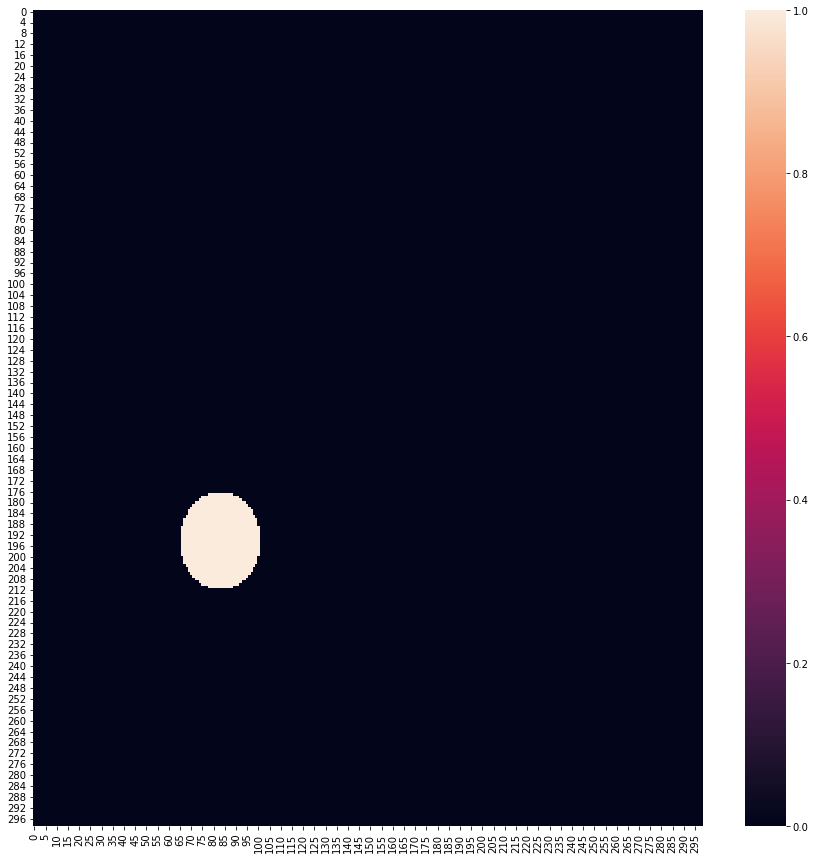

In [17]:

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(imm[0,:,:,2], ax=ax)

In [34]:
def cnn_model(kernel_lam, bias_lam):
    inputs = Input(shape=(max_x, max_y, number_image_channels))
    convolution_filter, dense_filter = 'relu', 'linear'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
#     base_model.trainable = False
    cnn = base_model(inputs, training=False)
#     cnn = base_model(inputs)
    
#     cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                              bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
#     cnn = layers.Dropout(0.5)(cnn)
    if True:
        # Convert features of shape `base_model.output_shape[1:]` to vectors
        cnn = layers.GlobalAveragePooling2D()(cnn)
        cnn = layers.Dense(2048, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
        cnn = layers.Dropout(0.5)(cnn)
        outputs = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init)(cnn)
        return Model(inputs, outputs)
    else:
        data_format="channels_last"
        filter_shape, pool_size = (1, 1), (2,2)
        cnn = layers.Conv2D(512, filter_shape, padding='same', 
                            activation=convolution_filter, data_format=data_format, 
                            kernel_regularizer=regularizers.l2(kernel_lam), 
                            bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(128, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(32, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(8, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(1, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.GlobalAveragePooling2D()(cnn)
        return Model(inputs, cnn)
    

class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, image_dir = image_dir, conserve=0):
#         print(dataset.shape[0])
#         print("generator initiated")
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
        self._image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
#         print('generator yielded a batch %d' % idx)
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels), 
                           dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self._image_dir)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y

class PredictBatchGenerator(Sequence):
    def __init__(self, dataset_size: int, batch_size: int, start_idx: int,
                 number_image_channels: int, max_x: int,
                 max_y: int, float_memory_used,
                 image_dir: str):
        self.dataset_size = dataset_size
        self.batch_size, self.start_idx = batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset_size / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
        size = min(self.dataset_size - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels),
                           dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self.image_dir)
        return batch_x
        
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)


In [41]:
# Xception model
model_name = "ResNet101"
base_model = applications.ResNet101(include_top=False, weights=None,
                                input_shape=(max_x, max_y, number_image_channels))
base_model.trainable = True
base_model.summary()

/home/shahrokh/miniconda3/envs/research/lib/python3.9/site-packages/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 8 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 300, 300, 8) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 8)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 25152       conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [12]:
# log-vgg pretrained - pu-setting
model_name = "log_vgg16"
fp_penalty_coef, fn_penalty_coef = 1, 1
model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/log/noisy_std_1/" + \
             "pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_8channels/models/vgg16/" + \
             "700000/best_model_lambda_0.1.h5"
model_path = "ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" + \
             "raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels_700k/models/700000/" + \
             "best_model_lambda_0_fit.h5"
base_model = models.load_model(model_path, 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model.trainable = False
base_model = base_model.layers[1]
base_model.summary()

2022-06-09 17:53:49.712847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 17:53:49.718095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 17:53:49.718537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 17:53:49.719328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [12]:
# log-vgg pretrained - ss-setting
model_name = "ResNet152V2"
fp_penalty_coef, fn_penalty_coef = 1, 1
base_model = models.load_model("/home/shahrokh/projects/MLSpectrumAllocation/ML/data/" +
                               "pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" +
                               "raw_power_min_max_norm/color/log_pu5_su6/" +
                               "variable_sensors_10_20_pus_5_sus_8_channels/models/ResNet152V2/" + 
                               "700000/best_model_lambda_0_1.h5", 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model = base_model.layers[1]
base_model.trainable = False
base_model.summary()

2022-06-05 11:19:50.879198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:19:50.882966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:19:50.883259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:19:50.883769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 8) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 8)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 25152       conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
from vit_keras import vit, utils
model_name = "vit_l16"
def transformer_model():
    model = vit.vit_l16(image_size=max_x, activation='linear',
                        pretrained=True, include_top=True, pretrained_top=False, classes=1)
    for l_index in range(len(model.layers) - 1):
        model.layers[l_index].trainable = False
    return model

In [ ]:
mod = transformer_model()

In [20]:
cnn1.layers[1].trainable

False

In [19]:
cnn1 = cnn_model(0, 0)

In [35]:
cnn1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 8)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14717568  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 15,770,241
Trainable params: 1,052,673
Non-trainable params: 14,717,568
_________________________________________

In [21]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
number_samples = [1024]

In [17]:
number_samples 

[8192]

In [12]:
number_samples = [700000]

In [23]:
# CNN: support batching
AUGMENTED = False
TEST, CONSERVE = True, False
mini_batch = 64 if max(max_x, max_y) == 1000 else 16
epochs = 35 if max(max_x, max_y) == 1000 else 100
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0] 
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1.5 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + ("aug/" if AUGMENTED else "") \
    + model_name + "/" + ("conservative/" if CONSERVE else "") + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            # =optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1/epochs, nesterov=False)
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb in lambda_vec]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb in lambda_vec]
    number_start = time.time()
    train_generator = DataBatchGenerator(
        dataset=data_reg_train[:number_sample * 4] if AUGMENTED else data_reg[:number_sample],
        batch_size=mini_batch,
        start_idx=prev_sample,
        number_image_channels=number_image_channels,
        max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
        image_dir=image_dir + ("/aug" if AUGMENTED else ""))
    

    val_size = math.ceil(number_sample * validation_size)
#     val_size = data_reg.shape[0] - number_sample
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    # ******************** fine-tunning *******
    print("******FINE TUNNING ******")
    # reloading the best
    cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'}) for lamb in lambda_vec]
    for cnn in cnns:
        cnn.trainable = True
        cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                    optimizer=optimizers.Adam(1e-4), 
                    metrics=['mse', 'mae', fp_mae])
    train_generator = DataBatchGenerator(
        dataset=data_reg_train[:number_sample * 4] if AUGMENTED else data_reg[:number_sample],
        batch_size=mini_batch,
        start_idx=prev_sample,
        number_image_channels=number_image_channels,
        max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
        image_dir=image_dir + ("/aug" if AUGMENTED else ""))
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=int(epochs//2), verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(lambda_vec[best_lamb_idx]) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
#         var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/models/' + model_name + "/"
#                      + intensity_degradation + '_' + str(slope) + '_' + 
#                      dtime + ".dat", "wb") # file for saving results
#         pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
#                      dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve,
#                      checkpointers],
#                     file=var_f)
#         var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 1024 , New samples: 1024
Validation size: 205 , starts: 1024 , ends: 1228


2022-06-09 17:55:16.081126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-09 17:55:17.513286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-06-09 17:55:20.122008: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


64/64 - 8s - loss: 148.4075 - mse: 148.4075 - mae: 8.7763 - fp_mae: 4.3849 - val_loss: 61.2394 - val_mse: 61.2394 - val_mae: 4.3195 - val_fp_mae: 3.2842

Epoch 00001: val_mae improved from inf to 4.31954, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_1_sus_3_channels/models/log_vgg16/1024/best_model_lambda_0.h5
Epoch 2/100
64/64 - 3s - loss: 251.6637 - mse: 251.6637 - mae: 8.7278 - fp_mae: 4.4464 - val_loss: 36.6462 - val_mse: 36.6462 - val_mae: 4.5722 - val_fp_mae: 3.8844

Epoch 00002: val_mae did not improve from 4.31954
Epoch 3/100
64/64 - 3s - loss: 272.3088 - mse: 272.3088 - mae: 7.6117 - fp_mae: 3.6448 - val_loss: 24.2086 - val_mse: 24.2086 - val_mae: 3.8205 - val_fp_mae: 1.5410

Epoch 00003: val_mae improved from 4.31954 to 3.82047, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_1_sus_3_channels/models/log_vgg16/1024/best_mode


Epoch 00033: val_mae did not improve from 3.52718
Epoch 34/100
64/64 - 3s - loss: 74.4497 - mse: 74.4497 - mae: 4.4054 - fp_mae: 2.1672 - val_loss: 22.0496 - val_mse: 22.0496 - val_mae: 3.6604 - val_fp_mae: 1.5075

Epoch 00034: val_mae did not improve from 3.52718
Epoch 35/100
64/64 - 3s - loss: 40.2764 - mse: 40.2764 - mae: 4.0487 - fp_mae: 2.0247 - val_loss: 21.2516 - val_mse: 21.2516 - val_mae: 3.6259 - val_fp_mae: 1.4485

Epoch 00035: val_mae did not improve from 3.52718
Epoch 36/100
64/64 - 3s - loss: 123.5392 - mse: 123.5392 - mae: 4.6528 - fp_mae: 2.1547 - val_loss: 26.7002 - val_mse: 26.7002 - val_mae: 3.6880 - val_fp_mae: 2.4457

Epoch 00036: val_mae did not improve from 3.52718
Epoch 37/100
64/64 - 3s - loss: 70.0416 - mse: 70.0416 - mae: 4.3516 - fp_mae: 2.3094 - val_loss: 23.4327 - val_mse: 23.4327 - val_mae: 3.8560 - val_fp_mae: 1.3017

Epoch 00037: val_mae did not improve from 3.52718
Epoch 38/100
64/64 - 3s - loss: 46.0843 - mse: 46.0843 - mae: 4.1869 - fp_mae: 1.9942 -

64/64 - 3s - loss: 24.1507 - mse: 24.1507 - mae: 3.6577 - fp_mae: 1.7934 - val_loss: 20.9781 - val_mse: 20.9781 - val_mae: 3.5356 - val_fp_mae: 1.8112

Epoch 00071: val_mae did not improve from 3.48078
Epoch 72/100
64/64 - 3s - loss: 37.1957 - mse: 37.1957 - mae: 3.8109 - fp_mae: 1.9069 - val_loss: 21.6597 - val_mse: 21.6597 - val_mae: 3.6245 - val_fp_mae: 1.7273

Epoch 00072: val_mae did not improve from 3.48078
Epoch 73/100
64/64 - 3s - loss: 49.3647 - mse: 49.3647 - mae: 3.8090 - fp_mae: 1.8472 - val_loss: 21.4344 - val_mse: 21.4344 - val_mae: 3.5646 - val_fp_mae: 1.9976

Epoch 00073: val_mae did not improve from 3.48078
Epoch 74/100
64/64 - 3s - loss: 37.1245 - mse: 37.1245 - mae: 3.8458 - fp_mae: 1.9449 - val_loss: 21.8435 - val_mse: 21.8435 - val_mae: 3.6437 - val_fp_mae: 1.5804

Epoch 00074: val_mae did not improve from 3.48078
Epoch 75/100
64/64 - 3s - loss: 29.1168 - mse: 29.1168 - mae: 3.7509 - fp_mae: 1.8467 - val_loss: 22.1173 - val_mse: 22.1173 - val_mae: 3.6674 - val_fp_m

Epoch 1/50
64/64 - 8s - loss: 27.7493 - mse: 27.7493 - mae: 3.8555 - fp_mae: 1.8859 - val_loss: 17.6468 - val_mse: 17.6468 - val_mae: 3.2654 - val_fp_mae: 1.2483

Epoch 00001: val_mae improved from 3.48078 to 3.26540, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_1_sus_3_channels/models/log_vgg16/1024/best_model_lambda_0.h5
Epoch 2/50
64/64 - 6s - loss: 16.2788 - mse: 16.2788 - mae: 3.0514 - fp_mae: 1.5505 - val_loss: 16.0061 - val_mse: 16.0061 - val_mae: 3.0883 - val_fp_mae: 1.2213

Epoch 00002: val_mae improved from 3.26540 to 3.08825, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_1_sus_3_channels/models/log_vgg16/1024/best_model_lambda_0.h5
Epoch 3/50
64/64 - 6s - loss: 12.6221 - mse: 12.6221 - mae: 2.6461 - fp_mae: 1.3142 - val_loss: 16.0382 - val_mse: 16.0382 - val_mae: 2.9453 - val_fp_mae: 1.5181

Epoch 00003: val_mae improved


Epoch 00033: val_mae did not improve from 2.81486
Epoch 34/50
64/64 - 7s - loss: 1.8568 - mse: 1.8568 - mae: 0.9836 - fp_mae: 0.4638 - val_loss: 15.2295 - val_mse: 15.2295 - val_mae: 2.8969 - val_fp_mae: 1.3076

Epoch 00034: val_mae did not improve from 2.81486
Epoch 35/50
64/64 - 6s - loss: 1.5155 - mse: 1.5155 - mae: 0.9004 - fp_mae: 0.4459 - val_loss: 15.4290 - val_mse: 15.4290 - val_mae: 2.8964 - val_fp_mae: 1.5734

Epoch 00035: val_mae did not improve from 2.81486
Epoch 36/50
64/64 - 6s - loss: 1.3710 - mse: 1.3710 - mae: 0.8813 - fp_mae: 0.4162 - val_loss: 15.5610 - val_mse: 15.5610 - val_mae: 2.9002 - val_fp_mae: 1.5400

Epoch 00036: val_mae did not improve from 2.81486
Epoch 37/50
64/64 - 6s - loss: 1.9056 - mse: 1.9056 - mae: 1.0373 - fp_mae: 0.5111 - val_loss: 15.4958 - val_mse: 15.4958 - val_mae: 2.8944 - val_fp_mae: 1.4872

Epoch 00037: val_mae did not improve from 2.81486
Epoch 38/50
64/64 - 6s - loss: 2.0828 - mse: 2.0828 - mae: 1.0858 - fp_mae: 0.5092 - val_loss: 14.786

In [31]:
# Saving images once to save time
# run this cell just for creating images
def creating_image_max_su_tot(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for row_idx in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        row_sample = data_reg[row_idx]
        row_sample[int(row_sample[0]) * 3 + 1] = 1
        for su_idx in range(int(data_max_su_tot[row_idx][0])):
            row_sample[int(row_sample[0]) * 3 + 2 : 
                       int(row_sample[0]) * 3 + 4] = data_max_su_tot[row_idx][1 + su_idx * 3: 
                                                                              1 + su_idx * 3 + 2]
            image = create_image(data=row_sample, 
                                 slope=slope, style=style, noise_floor=noise_floor,
                                 pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                                 sensors_num=(sensors_num if sensors else 0), 
                                 intensity_degradation=intensity_degradation, 
                                 max_pu_power=0.0 if not sensors else -60,
                                 max_su_power=40.0)
            if False and style == "image_intensity":
                if number_image_channels != 3:
                    image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                                   dtype=float_memory_used), axis=0)
                image_save = np.swapaxes(image, 0, 2)
                plt.imsave(max_su_image_dir + '/image' + str(image_num)+'.png', image_save)
            elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        #         np.save(max_su_image_dir + '/image' + str(image_num), image)
    #             np.savez_compressed(f"{image_dir}{(600000 + image_num)//100000}/image{600000 + image_num}",
    #                                 a=np.expand_dims(image,0))
                np.savez_compressed(f"{max_su_image_dir}/image{row_idx * 5 + su_idx}",
                                    a=np.expand_dims(image,0))
            del image

In [32]:
model_name = "log_vgg16_max_su_total"
max_su_image_dir = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name + "/images"
if not os.path.exists(max_su_image_dir):
        os.makedirs(max_su_image_dir)
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image_max_su_tot, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|█████████████████████████████████████| 2680/2680 [1:07:55<00:00,  1.52s/it]


In [228]:
max_su_image_dir

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/images'

In [85]:
# Multi-SU using single deep-alloc and another NN
# Create dataset

number_samples = [128, 256, 512, 1024, 2048, 4096]
MAX_QUEUE_SIZE, WORKERS = 28, 4
mini_batch = 128
fp_penalty_coef, fn_penalty_coef = 1, 1
dataset_path = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name

model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" + \
             "splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/" + \
             "pus_1_sus_3_channels/models/log_vgg16/"
y = np.copy(data_max_su_tot[:,3::3])

for number_sample in number_samples:
    model = models.load_model(f"{model_path}/{number_sample}/best_model_lambda_0.h5",
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef),
                                              'fp_mae': fp_mae,
                                              'mae':'mae', 'mse':'mse'})
    model.trainable = False
    predic_batch_generator = PredictBatchGenerator(dataset_size=data_reg.shape[0] * max_sus_num,
                                                   batch_size=mini_batch,
                                                   image_dir=max_su_image_dir,
                                                   max_x=max_x, max_y=max_y, 
                                                   number_image_channels=number_image_channels,
                                                   start_idx=0, float_memory_used=float_memory_used)
    number_dataset_path = f"{dataset_path}/{number_sample}"
    if not os.path.exists(number_dataset_path):
        os.makedirs(number_dataset_path)
    predict_power = model.predict(predic_batch_generator, verbose=1, 
                                  workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                  use_multiprocessing=False)
    X = np.copy(data_max_su_tot[:, 1:])
    X[:,2::3] = predict_power.reshape(data_reg.shape[0], max_sus_num)
    
    np.savetxt(f"{number_dataset_path}/X.txt", X, delimiter=",")
    np.savetxt(f"{number_dataset_path}/y.txt", y, delimiter=",")
    print(f"{number_sample} finished.")

1257/1257 [==============================] - 241s 192ms/step
128 finished.
1257/1257 [==============================] - 244s 194ms/step
256 finished.
1257/1257 [==============================] - 244s 194ms/step
512 finished.
1257/1257 [==============================] - 244s 194ms/step
1024 finished.
1257/1257 [==============================] - 244s 194ms/step
2048 finished.
1257/1257 [==============================] - 244s 194ms/step
4096 finished.


In [184]:
def nn_model(n_inputs: int, n_outputs:int, kernel_lam, bias_lam, num_hidden_layers = 2, num_neurons = 100):
    hidden_filter, last_layer_filter = 'relu', 'linear'
    hidden_init, last_layer_init = "lecun_normal", "RandomNormal"  #he_uniform
    model = Sequential()
    for _ in range(num_hidden_layers):
        model.add(layers.Dense(num_neurons,
                              input_dim=n_inputs, 
                               kernel_initializer=hidden_init,
                               activation=hidden_filter,
                               kernel_regularizer=regularizers.l2(kernel_lam), 
                               bias_regularizer=regularizers.l2(bias_lam)))
        model.add(BatchNormalization())
    model.add(layers.Dropout(0.8))
    model.add(layers.Dense(n_outputs, 
                           kernel_initializer=last_layer_init, 
                           activation=last_layer_filter,
                           kernel_regularizer=regularizers.l2(kernel_lam),
                           bias_regularizer=regularizers.l2(bias_lam)))
    return model
        
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)

def cus_mae(y_true, y_pred):
    def log10(x):
        numerator = K.log(x)
        denominator = K.log(K.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    p_true = K.sum(K.pow(10.0, y_true/10))
    p_pred = K.sum(K.pow(10.0, y_pred/10))
    return K.mean(K.abs(10 * log10(p_true) - 10 * log10(p_pred)))


In [187]:
# CNN + NN(multi-SUs): support batching
TEST, CONSERVE = True, False
mini_batch = 64 if max(max_x, max_y) == 1000 else 16
epochs = 35 if max(max_x, max_y) == 1000 else 300
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_cus_mae", 'min'  # the metric that hyper parameters are tuned with
lambda_vec = [0, 0.01, 0.1, 1, 10] 
prev_sample = 0
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
total_power = []
number_samples = [128, 256, 512, 1024, 2048, 4096]

for num_sample_idx, number_sample in enumerate(number_samples):
    MODEL_PATH = f"{dataset_path}/{number_sample}/models"
    X = np.loadtxt(f"{dataset_path}/{number_sample}/X.txt", delimiter=",")
    y = np.loadtxt(f"{dataset_path}/{number_sample}/y.txt", delimiter=",")
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        nns = [nn_model(max_sus_num * 3, max_sus_num, kernel_lam=lamb, bias_lam=0,
                        num_hidden_layers=4, num_neurons=200)
               for lamb in lambda_vec]
        for nn in nns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            # =optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1/epochs, nesterov=False)
            nn.compile(loss="mse", 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', cus_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb)+ '.h5',
                                         verbose=0, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb in lambda_vec]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb in lambda_vec]
    number_start = time.time()
    val_size = math.ceil(number_sample * validation_size)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        nns[lamb_idx].fit(x=X[:number_sample+val_size,:],
                           y=y[:number_sample+val_size,:],
                           epochs=epochs, verbose=0,
                           validation_split=validation_size/(1 + validation_size), 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(nns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in nns[lamb_idx].history.history['mae']])
#         print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
#               [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(nns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in nns[lamb_idx].history.history['val_mae']])
        print("Val custom mae Error(all epochs):", min(nns[lamb_idx].history.history['val_cus_mae']), '\n',
              [round(val,3) for val in nns[lamb_idx].history.history['val_cus_mae']])
    
    
    models_min_mae = [min(nns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(nns)
    del nns
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(lambda_vec[best_lamb_idx]) + '.h5', 
                                       custom_objects={'mae': 'mae', 'mse': 'mse', 'cus_mae': cus_mae})
#                                        custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
#                                                        'fp_mae': fp_mae,
#                                                       'mae':'mae', 'mse':'mse'})

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
#         test_res = best_model.evaluate(test_generator, verbose=1, 
#                                        workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        y_hat = best_model.predict(X[number_sample + val_size:, :], verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        total_power.append(np.mean(10 * np.log10(np.sum(10**(y_hat/10), axis=1))))
        average_diff_power.append(np.mean(np.abs(
            10 * np.log10(np.sum(10 ** (y_hat/10), axis=1)) -
            10 * np.log10(np.sum(10 ** (y[number_sample + val_size:]/10), axis=1)))))
        
#         test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
#                                          for mtrc in ['mae','fp_mae']]
#         test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
#         average_diff_power.append(round(test_mae, 3))
#         fp_mean_power.append(round(test_fp_mae, 3))
        print('total_power: ', total_power[-1], ', average_difference: ', average_diff_power[-1])
        
        
        print("\n\n")

        
#         var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/models/' + model_name + "/"
#                      + intensity_degradation + '_' + str(slope) + '_' + 
#                      dtime + ".dat", "wb") # file for saving results
#         pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
#                      dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve,
#                      checkpointers],
#                     file=var_f)
#         var_f.close()
        del best_model
#     prev_sample = number_sample

number_samples: 128 , New samples: 128
Validation size: 26 , starts: 128 , ends: 153

Lambda: 0 , Time: 0:00:07
Train Error(all epochs): 2.7973647117614746 
 [8.269, 8.072, 8.019, 7.81, 7.861, 7.741, 7.667, 7.55, 7.487, 7.453, 7.325, 7.302, 7.136, 7.113, 6.993, 7.042, 6.847, 6.731, 6.623, 6.594, 6.462, 6.602, 6.405, 6.185, 6.027, 6.143, 6.159, 5.829, 5.802, 5.839, 5.487, 5.564, 5.495, 5.534, 5.407, 5.244, 5.009, 5.1, 4.894, 4.816, 4.918, 4.897, 4.813, 4.661, 4.636, 4.545, 4.416, 4.513, 4.339, 4.275, 4.124, 4.18, 4.233, 4.222, 4.366, 3.898, 4.122, 3.894, 4.105, 4.012, 3.83, 3.987, 4.023, 3.842, 3.839, 3.935, 3.989, 4.055, 3.54, 3.807, 3.77, 3.842, 3.797, 3.61, 3.747, 3.722, 3.787, 3.727, 3.686, 3.702, 3.831, 3.527, 3.644, 3.651, 3.569, 3.734, 3.632, 3.408, 3.475, 3.603, 3.775, 3.803, 3.567, 3.558, 3.792, 3.592, 3.419, 3.306, 3.417, 3.365, 3.461, 3.35, 3.361, 3.506, 3.401, 3.374, 3.563, 3.435, 3.372, 3.316, 3.268, 3.513, 3.704, 3.219, 3.425, 3.388, 3.441, 3.447, 3.557, 3.439, 3.26, 3.438


Lambda: 0.1 , Time: 0:00:08
Train Error(all epochs): 2.863245964050293 
 [8.167, 7.931, 7.912, 7.804, 7.712, 7.665, 7.528, 7.471, 7.373, 7.31, 7.212, 7.144, 7.039, 7.051, 6.865, 6.814, 6.686, 6.603, 6.504, 6.503, 6.483, 6.217, 6.129, 6.019, 6.097, 5.748, 5.857, 5.685, 5.382, 5.709, 5.425, 5.26, 5.212, 5.427, 5.191, 5.043, 4.961, 4.917, 4.911, 4.882, 4.823, 4.722, 4.644, 4.738, 4.635, 4.377, 4.634, 4.495, 4.27, 4.245, 3.944, 4.245, 4.276, 4.151, 4.008, 4.016, 3.803, 4.062, 3.823, 4.04, 4.145, 3.93, 3.972, 3.845, 3.835, 3.668, 3.787, 3.876, 3.829, 3.615, 3.636, 3.997, 3.654, 3.647, 3.606, 3.761, 3.568, 3.318, 3.47, 3.533, 3.707, 3.713, 3.302, 3.563, 3.841, 3.638, 3.437, 3.804, 3.62, 3.607, 3.62, 3.633, 3.485, 3.418, 3.639, 3.238, 3.976, 3.547, 3.462, 3.54, 3.461, 3.24, 3.391, 3.601, 3.374, 3.481, 3.361, 3.499, 3.62, 3.356, 3.374, 3.521, 3.256, 3.301, 3.723, 3.463, 3.419, 3.275, 3.424, 3.582, 3.457, 3.266, 3.418, 3.469, 3.101, 3.366, 3.434, 3.511, 3.346, 3.469, 3.378, 3.623, 3.379, 3.356


Lambda: 10 , Time: 0:00:07
Train Error(all epochs): 3.838141679763794 
 [8.18, 8.174, 8.075, 8.002, 8.078, 8.089, 8.019, 7.966, 7.884, 7.873, 7.871, 7.799, 7.773, 7.789, 7.736, 7.712, 7.677, 7.646, 7.687, 7.595, 7.59, 7.519, 7.567, 7.413, 7.453, 7.378, 7.302, 7.267, 7.214, 7.242, 7.133, 7.046, 7.016, 6.956, 7.013, 6.833, 6.829, 6.803, 6.719, 6.663, 6.69, 6.588, 6.652, 6.491, 6.413, 6.64, 6.601, 6.389, 6.377, 6.36, 6.322, 6.212, 6.356, 6.369, 6.284, 6.231, 6.177, 6.199, 6.001, 5.955, 5.992, 6.05, 6.03, 6.005, 5.93, 5.845, 6.068, 6.005, 5.915, 5.934, 5.964, 5.886, 5.871, 5.798, 5.781, 5.88, 5.765, 5.673, 5.651, 5.605, 5.684, 5.463, 5.663, 5.723, 5.627, 5.471, 5.628, 5.572, 5.452, 5.536, 5.506, 5.376, 5.353, 5.395, 5.386, 5.326, 5.152, 5.186, 5.265, 5.351, 5.317, 5.159, 5.331, 5.163, 5.151, 5.163, 4.837, 5.035, 5.109, 4.959, 4.921, 4.866, 4.905, 4.965, 5.002, 4.946, 4.939, 5.054, 4.987, 5.048, 4.97, 5.078, 4.962, 5.018, 4.921, 4.902, 4.825, 4.783, 4.662, 4.758, 4.804, 4.714, 4.729, 4.741


Lambda: 0.01 , Time: 0:00:09
Train Error(all epochs): 2.798269748687744 
 [8.011, 7.875, 7.789, 7.64, 7.439, 7.332, 7.295, 7.144, 6.948, 6.912, 6.727, 6.561, 6.417, 6.313, 6.067, 5.894, 5.76, 5.718, 5.544, 5.424, 5.326, 5.211, 5.161, 4.943, 4.886, 4.714, 4.704, 4.566, 4.656, 4.486, 4.337, 4.387, 4.325, 4.036, 4.061, 4.144, 4.115, 4.05, 3.988, 3.884, 3.839, 3.751, 3.914, 3.933, 3.769, 3.798, 3.812, 3.643, 3.762, 3.746, 3.655, 3.521, 3.715, 3.527, 3.546, 3.671, 3.757, 3.574, 3.484, 3.555, 3.556, 3.55, 3.513, 3.454, 3.463, 3.58, 3.557, 3.493, 3.521, 3.46, 3.335, 3.493, 3.567, 3.505, 3.416, 3.446, 3.392, 3.515, 3.423, 3.369, 3.405, 3.322, 3.258, 3.392, 3.591, 3.227, 3.356, 3.295, 3.214, 3.434, 3.454, 3.294, 3.501, 3.25, 3.303, 3.44, 3.22, 3.315, 3.228, 3.148, 3.186, 3.315, 3.189, 3.423, 3.324, 3.244, 3.441, 3.363, 3.249, 3.448, 3.37, 3.309, 3.397, 3.242, 3.428, 3.23, 3.259, 3.149, 3.369, 3.291, 3.151, 3.194, 3.303, 3.15, 3.238, 3.181, 3.359, 3.294, 3.261, 3.213, 3.297, 3.259, 3.241, 3.057


Lambda: 1 , Time: 0:00:09
Train Error(all epochs): 3.113250732421875 
 [8.087, 7.894, 7.759, 7.63, 7.639, 7.443, 7.361, 7.276, 7.038, 6.932, 6.83, 6.71, 6.466, 6.251, 6.053, 6.02, 5.891, 5.733, 5.531, 5.442, 5.296, 5.267, 4.996, 5.025, 4.971, 4.806, 4.656, 4.741, 4.627, 4.6, 4.691, 4.542, 4.459, 4.52, 4.62, 4.371, 4.479, 4.391, 4.31, 4.342, 4.336, 4.341, 4.12, 4.123, 4.093, 4.002, 4.233, 3.96, 4.127, 4.014, 4.085, 4.11, 4.18, 4.1, 4.058, 4.108, 4.027, 4.069, 3.913, 3.889, 3.935, 3.99, 3.929, 3.862, 3.913, 4.063, 3.824, 3.913, 3.906, 3.809, 3.726, 3.985, 3.797, 3.719, 3.975, 3.769, 3.609, 3.717, 3.764, 3.724, 3.782, 3.859, 3.801, 3.892, 3.876, 3.652, 3.706, 3.622, 3.571, 3.58, 3.725, 3.555, 3.806, 3.787, 3.909, 3.873, 3.898, 3.834, 3.83, 3.707, 3.517, 3.587, 3.53, 3.487, 3.623, 3.659, 3.56, 3.728, 3.811, 3.719, 3.496, 3.59, 3.567, 3.659, 3.489, 3.884, 3.697, 3.685, 3.518, 3.669, 3.517, 3.671, 3.655, 3.601, 3.606, 3.712, 3.6, 3.535, 3.527, 3.455, 3.553, 3.511, 3.659, 3.721, 3.458, 3.614

996/996 [==============================] - 1s 490us/step
total_power:  16.938116 , average_difference:  3.784753627462606



number_samples: 512 , New samples: 512
Validation size: 103 , starts: 512 , ends: 614

Lambda: 0 , Time: 0:00:13
Train Error(all epochs): 2.8363325595855713 
 [8.083, 7.894, 7.716, 7.542, 7.325, 7.08, 6.792, 6.596, 6.351, 6.081, 5.984, 5.673, 5.538, 5.315, 5.185, 5.115, 4.902, 4.723, 4.674, 4.526, 4.483, 4.412, 4.366, 4.308, 4.278, 4.231, 4.121, 3.993, 4.123, 4.055, 4.162, 3.982, 3.994, 3.895, 3.981, 3.998, 3.896, 4.004, 3.926, 3.886, 3.744, 3.949, 3.768, 3.785, 3.862, 3.78, 3.738, 3.702, 3.73, 3.711, 3.74, 3.67, 3.646, 3.576, 3.73, 3.568, 3.589, 3.628, 3.655, 3.532, 3.573, 3.648, 3.549, 3.631, 3.555, 3.44, 3.502, 3.559, 3.456, 3.588, 3.457, 3.495, 3.586, 3.543, 3.534, 3.506, 3.448, 3.481, 3.433, 3.438, 3.314, 3.327, 3.385, 3.521, 3.48, 3.398, 3.389, 3.338, 3.528, 3.459, 3.395, 3.582, 3.357, 3.516, 3.368, 3.345, 3.368, 3.34, 3.397, 3.372, 3.366, 3.377, 3.267, 3.3


Lambda: 0.1 , Time: 0:00:13
Train Error(all epochs): 3.1136972904205322 
 [8.086, 7.865, 7.698, 7.535, 7.389, 7.129, 6.91, 6.57, 6.384, 6.127, 5.842, 5.625, 5.419, 5.152, 5.099, 5.017, 4.804, 4.648, 4.536, 4.542, 4.436, 4.431, 4.306, 4.338, 4.14, 4.24, 4.362, 4.216, 4.205, 4.178, 4.094, 4.041, 4.048, 3.835, 4.02, 4.091, 3.786, 3.942, 3.892, 3.895, 3.873, 3.761, 3.886, 3.823, 3.83, 3.786, 3.819, 3.78, 3.643, 3.862, 3.821, 3.666, 3.749, 3.719, 3.703, 3.784, 3.715, 3.648, 3.545, 3.735, 3.635, 3.57, 3.655, 3.619, 3.682, 3.586, 3.613, 3.643, 3.578, 3.612, 3.659, 3.575, 3.635, 3.612, 3.506, 3.616, 3.539, 3.637, 3.414, 3.669, 3.461, 3.57, 3.535, 3.465, 3.6, 3.514, 3.5, 3.544, 3.494, 3.62, 3.509, 3.553, 3.449, 3.519, 3.501, 3.436, 3.482, 3.5, 3.39, 3.437, 3.511, 3.459, 3.46, 3.437, 3.509, 3.457, 3.443, 3.399, 3.4, 3.358, 3.486, 3.526, 3.458, 3.467, 3.418, 3.466, 3.416, 3.498, 3.452, 3.385, 3.426, 3.451, 3.357, 3.384, 3.407, 3.453, 3.483, 3.319, 3.36, 3.319, 3.415, 3.452, 3.515, 3.356, 3.415, 


Lambda: 10 , Time: 0:00:13
Train Error(all epochs): 5.308837413787842 
 [8.12, 7.985, 7.954, 7.895, 7.855, 7.741, 7.663, 7.499, 7.363, 7.284, 7.15, 7.07, 6.942, 6.891, 6.918, 6.865, 6.839, 6.789, 6.667, 6.706, 6.687, 6.661, 6.662, 6.532, 6.497, 6.544, 6.403, 6.433, 6.274, 6.31, 6.331, 6.223, 6.213, 6.117, 6.116, 6.097, 6.136, 6.144, 6.093, 6.13, 6.104, 6.059, 6.01, 6.031, 6.041, 5.974, 5.923, 5.95, 6.003, 5.972, 5.953, 6.04, 5.987, 6.033, 5.958, 6.078, 5.981, 5.85, 5.996, 6.023, 6.018, 5.972, 5.91, 5.861, 5.877, 5.997, 5.944, 5.96, 5.935, 5.864, 5.874, 5.798, 5.883, 5.883, 5.896, 5.874, 5.859, 5.836, 5.916, 5.848, 5.793, 5.875, 5.865, 5.833, 5.771, 5.801, 5.793, 5.895, 5.811, 5.799, 5.755, 5.793, 5.743, 5.833, 5.724, 5.672, 5.628, 5.723, 5.785, 5.776, 5.759, 5.665, 5.666, 5.753, 5.729, 5.758, 5.732, 5.67, 5.682, 5.7, 5.709, 5.714, 5.74, 5.649, 5.783, 5.758, 5.688, 5.745, 5.741, 5.653, 5.571, 5.739, 5.713, 5.66, 5.671, 5.667, 5.659, 5.686, 5.648, 5.667, 5.779, 5.637, 5.659, 5.68, 5.679


Lambda: 0.01 , Time: 0:00:20
Train Error(all epochs): 3.096693277359009 
 [8.169, 7.833, 7.344, 6.874, 6.432, 6.161, 5.733, 5.585, 5.367, 5.038, 5.008, 4.92, 4.761, 4.766, 4.71, 4.719, 4.655, 4.543, 4.573, 4.54, 4.557, 4.47, 4.391, 4.425, 4.382, 4.315, 4.207, 4.321, 4.26, 4.308, 4.258, 4.138, 4.179, 4.159, 4.072, 4.107, 4.106, 4.066, 4.115, 4.124, 4.074, 4.004, 3.978, 4.021, 4.017, 3.99, 3.938, 3.928, 3.952, 3.961, 3.934, 3.912, 3.952, 3.851, 3.91, 3.88, 3.79, 3.768, 3.778, 3.729, 3.703, 3.803, 3.776, 3.782, 3.782, 3.675, 3.702, 3.74, 3.669, 3.67, 3.623, 3.719, 3.71, 3.729, 3.647, 3.681, 3.643, 3.677, 3.575, 3.684, 3.647, 3.551, 3.623, 3.62, 3.623, 3.657, 3.554, 3.61, 3.517, 3.594, 3.577, 3.645, 3.516, 3.563, 3.529, 3.512, 3.525, 3.601, 3.545, 3.527, 3.514, 3.539, 3.518, 3.509, 3.514, 3.433, 3.543, 3.573, 3.446, 3.377, 3.433, 3.428, 3.365, 3.432, 3.447, 3.454, 3.441, 3.455, 3.38, 3.367, 3.39, 3.453, 3.35, 3.439, 3.41, 3.353, 3.396, 3.375, 3.327, 3.408, 3.446, 3.37, 3.348, 3.295, 3.345


Lambda: 1 , Time: 0:00:22
Train Error(all epochs): 3.9574944972991943 
 [8.261, 7.943, 7.589, 7.095, 6.627, 6.29, 6.0, 5.82, 5.542, 5.544, 5.421, 5.303, 5.275, 5.262, 5.176, 5.138, 5.141, 5.054, 5.019, 5.03, 4.954, 5.002, 4.971, 4.994, 4.898, 4.854, 4.871, 4.919, 4.999, 4.97, 4.881, 5.001, 4.954, 4.821, 4.875, 4.815, 4.912, 4.813, 4.944, 4.882, 4.8, 4.892, 4.843, 4.712, 4.848, 4.85, 4.817, 4.883, 4.798, 4.747, 4.814, 4.774, 4.663, 4.814, 4.848, 4.717, 4.755, 4.782, 4.774, 4.821, 4.782, 4.743, 4.74, 4.758, 4.775, 4.683, 4.765, 4.623, 4.701, 4.781, 4.69, 4.731, 4.689, 4.691, 4.748, 4.644, 4.6, 4.708, 4.673, 4.628, 4.6, 4.655, 4.69, 4.626, 4.705, 4.699, 4.685, 4.571, 4.656, 4.672, 4.678, 4.603, 4.62, 4.644, 4.593, 4.645, 4.684, 4.593, 4.565, 4.575, 4.64, 4.481, 4.609, 4.613, 4.599, 4.498, 4.55, 4.537, 4.457, 4.565, 4.542, 4.557, 4.455, 4.514, 4.548, 4.574, 4.513, 4.51, 4.519, 4.419, 4.389, 4.461, 4.475, 4.52, 4.555, 4.417, 4.546, 4.53, 4.417, 4.435, 4.399, 4.368, 4.481, 4.492, 4.457, 4.4

967/967 [==============================] - 1s 483us/step
total_power:  16.206432 , average_difference:  3.548662208542994



number_samples: 2048 , New samples: 2048
Validation size: 410 , starts: 2048 , ends: 2457

Lambda: 0 , Time: 0:00:34
Train Error(all epochs): 3.139981269836426 
 [8.034, 7.415, 6.613, 5.945, 5.433, 5.194, 5.129, 4.988, 4.933, 4.873, 4.849, 4.788, 4.742, 4.714, 4.71, 4.653, 4.626, 4.614, 4.573, 4.521, 4.531, 4.447, 4.486, 4.494, 4.452, 4.479, 4.463, 4.358, 4.34, 4.298, 4.282, 4.365, 4.347, 4.268, 4.299, 4.306, 4.285, 4.176, 4.157, 4.247, 4.202, 4.158, 4.146, 4.165, 4.113, 4.086, 4.1, 4.072, 4.028, 3.998, 4.026, 4.012, 3.95, 3.961, 4.02, 3.96, 3.933, 3.88, 3.936, 3.979, 3.93, 3.938, 3.896, 3.88, 3.83, 3.848, 3.782, 3.766, 3.803, 3.806, 3.826, 3.795, 3.841, 3.765, 3.798, 3.771, 3.729, 3.726, 3.748, 3.701, 3.767, 3.765, 3.691, 3.703, 3.649, 3.657, 3.669, 3.72, 3.651, 3.669, 3.65, 3.641, 3.689, 3.678, 3.616, 3.68, 3.655, 3.583, 3.572, 3.65, 3.588, 3.588, 3.598, 3.531,


Lambda: 0.1 , Time: 0:00:36
Train Error(all epochs): 3.821125030517578 
 [7.983, 7.317, 6.525, 5.898, 5.476, 5.232, 5.099, 5.106, 4.995, 4.888, 4.881, 4.898, 4.85, 4.85, 4.825, 4.795, 4.749, 4.75, 4.764, 4.703, 4.791, 4.706, 4.621, 4.684, 4.601, 4.719, 4.623, 4.668, 4.624, 4.656, 4.566, 4.511, 4.566, 4.539, 4.594, 4.573, 4.57, 4.513, 4.496, 4.56, 4.477, 4.499, 4.484, 4.429, 4.383, 4.452, 4.377, 4.357, 4.411, 4.304, 4.405, 4.355, 4.321, 4.369, 4.367, 4.365, 4.329, 4.324, 4.254, 4.306, 4.29, 4.334, 4.343, 4.293, 4.363, 4.285, 4.301, 4.255, 4.214, 4.193, 4.191, 4.249, 4.181, 4.208, 4.236, 4.255, 4.136, 4.171, 4.195, 4.168, 4.255, 4.202, 4.135, 4.189, 4.162, 4.247, 4.094, 4.192, 4.157, 4.097, 4.198, 4.185, 4.181, 4.153, 4.195, 4.095, 4.2, 4.083, 4.187, 4.166, 4.112, 4.2, 4.103, 4.091, 4.093, 4.106, 4.073, 4.055, 4.047, 4.122, 4.063, 4.134, 4.177, 4.05, 4.093, 4.011, 4.026, 4.077, 4.129, 4.048, 4.027, 4.047, 4.042, 4.098, 4.053, 4.034, 4.064, 4.079, 4.05, 4.095, 4.124, 4.039, 4.051, 4.043,


Lambda: 10 , Time: 0:00:36
Train Error(all epochs): 5.68642520904541 
 [8.107, 7.82, 7.384, 7.117, 6.981, 6.823, 6.677, 6.579, 6.519, 6.428, 6.397, 6.391, 6.356, 6.308, 6.286, 6.266, 6.257, 6.23, 6.217, 6.264, 6.204, 6.154, 6.12, 6.106, 6.107, 6.129, 6.081, 6.038, 6.048, 6.067, 6.055, 6.041, 6.032, 6.03, 6.01, 6.003, 6.013, 6.016, 5.944, 6.008, 5.986, 5.992, 5.945, 5.956, 5.942, 5.917, 5.933, 5.925, 5.989, 5.937, 5.962, 5.961, 5.949, 5.925, 5.917, 5.903, 5.913, 5.882, 5.874, 5.892, 5.902, 5.857, 5.888, 5.878, 5.879, 5.862, 5.891, 5.849, 5.852, 5.855, 5.904, 5.839, 5.877, 5.818, 5.836, 5.852, 5.829, 5.863, 5.828, 5.841, 5.866, 5.845, 5.813, 5.814, 5.846, 5.825, 5.821, 5.82, 5.841, 5.797, 5.836, 5.793, 5.813, 5.828, 5.81, 5.832, 5.804, 5.82, 5.822, 5.799, 5.82, 5.799, 5.817, 5.799, 5.788, 5.795, 5.806, 5.8, 5.786, 5.816, 5.761, 5.807, 5.752, 5.771, 5.803, 5.758, 5.807, 5.795, 5.79, 5.733, 5.79, 5.786, 5.784, 5.803, 5.745, 5.786, 5.773, 5.774, 5.745, 5.743, 5.749, 5.77, 5.733, 5.761, 5.7


Lambda: 0.01 , Time: 0:01:07
Train Error(all epochs): 3.683232307434082 
 [7.62, 6.208, 5.368, 5.082, 4.988, 4.926, 4.886, 4.825, 4.838, 4.767, 4.746, 4.729, 4.729, 4.696, 4.684, 4.665, 4.655, 4.645, 4.608, 4.631, 4.623, 4.559, 4.574, 4.576, 4.513, 4.514, 4.548, 4.505, 4.49, 4.482, 4.468, 4.427, 4.413, 4.478, 4.423, 4.387, 4.422, 4.355, 4.389, 4.326, 4.324, 4.316, 4.327, 4.296, 4.315, 4.268, 4.283, 4.255, 4.251, 4.267, 4.261, 4.204, 4.244, 4.2, 4.198, 4.199, 4.205, 4.162, 4.141, 4.167, 4.14, 4.136, 4.117, 4.146, 4.109, 4.132, 4.103, 4.08, 4.119, 4.09, 4.076, 4.103, 4.086, 4.058, 4.104, 4.1, 4.076, 4.043, 4.059, 4.074, 4.029, 4.042, 4.025, 4.012, 3.984, 4.059, 3.969, 4.023, 3.969, 4.053, 3.969, 3.977, 3.963, 3.999, 3.976, 3.937, 4.029, 3.96, 3.941, 3.98, 3.953, 3.92, 3.967, 3.898, 3.937, 3.925, 3.932, 3.948, 3.907, 3.964, 3.938, 3.934, 3.925, 3.937, 3.956, 3.848, 3.915, 3.865, 3.923, 3.889, 3.919, 3.885, 3.848, 3.879, 3.871, 3.886, 3.887, 3.9, 3.913, 3.9, 3.862, 3.894, 3.903, 3.899, 3.


Lambda: 1 , Time: 0:01:06
Train Error(all epochs): 4.7012739181518555 
 [7.634, 6.268, 5.672, 5.462, 5.324, 5.313, 5.257, 5.202, 5.198, 5.186, 5.119, 5.172, 5.146, 5.15, 5.135, 5.166, 5.094, 5.115, 5.104, 5.127, 5.078, 5.069, 5.113, 5.083, 5.081, 5.065, 5.099, 5.064, 5.094, 5.099, 5.076, 5.034, 5.031, 5.055, 5.025, 5.012, 5.027, 5.02, 5.022, 4.996, 5.025, 4.972, 5.001, 4.998, 4.994, 4.971, 5.0, 4.967, 4.995, 4.966, 4.959, 4.972, 4.935, 4.943, 4.976, 4.897, 4.927, 4.967, 4.919, 4.931, 4.906, 4.951, 4.906, 4.911, 4.923, 4.864, 4.876, 4.922, 4.882, 4.892, 4.861, 4.917, 4.876, 4.877, 4.862, 4.889, 4.895, 4.889, 4.853, 4.817, 4.868, 4.869, 4.857, 4.862, 4.871, 4.876, 4.814, 4.885, 4.863, 4.8, 4.83, 4.811, 4.836, 4.831, 4.841, 4.817, 4.823, 4.816, 4.81, 4.848, 4.813, 4.84, 4.812, 4.851, 4.819, 4.823, 4.799, 4.832, 4.821, 4.811, 4.813, 4.774, 4.803, 4.825, 4.815, 4.799, 4.831, 4.783, 4.777, 4.804, 4.815, 4.815, 4.814, 4.775, 4.792, 4.773, 4.804, 4.753, 4.803, 4.799, 4.788, 4.76, 4.799, 4.794

852/852 [==============================] - 0s 466us/step
total_power:  14.704907 , average_difference:  3.5641578196004184





In [188]:
print(average_diff_power)
print(total_power)
print(best_lambda)

[4.623081284800603, 3.784753627462606, 3.571933018213715, 3.548662208542994, 3.656685618471818, 3.5641578196004184]
[14.425347, 16.938116, 16.020887, 16.206432, 17.342045, 14.704907]
[0.1, 10, 10, 1, 10, 10]


In [ ]:
# multi-su simulatnous
# minimized by min cus_mae
[4.623081284800603, 3.784753627462606, 3.571933018213715, 3.548662208542994, 3.656685618471818, 3.5641578196004184]
[14.425347, 16.938116, 16.020887, 16.206432, 17.342045, 14.704907]
[0.1, 10, 10, 1, 10, 10]
# minimized by min mae
[4.607942885709469, 4.195705268601129, 3.6685070016249486, 3.639623614150089, 3.3137235937382084, 3.2712268522580983]
[12.675369, 14.197315, 14.086546, 14.06105, 14.185148, 13.945412]
[10, 0, 0.01, 1, 1, 1]

In [191]:
all_cnns[0][0].layers

In [ ]:
# Multi-SU using single deep-alloc and Bi-LSTM
# DataBatchGenerator

class LSTMBatchGenerator(Sequence):
    def __init__(self, dataset, batch_size: int, start_idx: int, float_memory_used,
                 image_dir: str, cnn_feature_model, num_sus, cnn_output_size):
        self.dataset = dataset
        self.batch_size, self.start_idx = batch_size, start_idx
#         self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.image_dir = image_dir
        self.cnn_feature_model = cnn_feature_model
        self.num_sus = num_sus
        self.cnn_output_size = cnn_output_size
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.num_sus, self.cnn_output_size),
                           dtype=self.float_memory_used)
        batch_y = np.copy(self.dataset[idx * self.batch_size: idx * self.batch_size + size, 3::3])
        batch_x2 = np.copy(batch_y)
        batch_x2[:, 1:] = batch_x2[:, :-1]
        batch_x2[:,0] = 0
        for i in range(size):
            for su_idx in range(self.num_sus):
                imm = read_image((self.start_idx + idx * self.batch_size + i) * self.num_sus + su_idx,
                                 self.image_dir)
                batch_x[i][su_idx] = self.cnn_feature_model.predict(imm)[0]
        return ([batch_x, batch_x2.reshape(size, self.num_sus, 1)], batch_y.reshape(size, self.num_sus, 1))

def create_bilstm_model(units, num_sus, cnn_output_size):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True), 
                                   input_shape=(num_sus, cnn_output_size)))
    model.add(layers.Bidirectional(layers.LSTM(units)))
    model.add(layers.Dense(1, activation='linear'))
    return model

def create_rnn_encoder_decoder(units, num_sus, cnn_output_size):
    # define bi-lstm encoder
    encoder_inputs = Input(shape=(None, cnn_output_size))
    encoder = layers.Bidirectional(layers.LSTM(units, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    # define training decoder
    decoder_inputs = Input(shape=(None, 1))
    decoder_lstm = layers.LSTM(units * 2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = layers.Dense(1, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model

def create_inference_model(model, units):
    #inference encoder
    encoder_inputs = model.input[0] #input_1
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = model.layers[1].output # lstm_1
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states)
    
    #inference decoder
    decoder_inputs = model.input[1] #input_2
    decoder_state_input_h = Input(shape=(units * 2,),name='input_3')
    decoder_state_input_c = Input(shape=(units * 2,),name='input_4')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[5]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[6]
    decoder_outputs=decoder_dense(decoder_outputs)

    decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                          [decoder_outputs] + decoder_states)
    return encoder_model, decoder_model

def predict_su_adjusted_power(inf_enc, inf_dec, num_sus, data):
    # encode
    state = inf_enc.predict(data)
    # start of sequence input
    target_seq = np.array([0.0]).reshape(1, 1, 1)
    # collect predictions
    output = list()
    for _ in range(num_sus):
        # predict next char
        yhat, h, c = inf_dec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return np.array(output)

model_name = "log_vgg16_max_su_total"
max_su_image_dir = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name + "/images"
number_samples = [128, 256, 512, 1024, 2048, 4096]
hyper_metric, mode = "val_cus_mae", 'min'
MAX_QUEUE_SIZE, WORKERS = 28, 4
lstm_units = 128
mini_batch, epochs = 32, 120
fp_penalty_coef, fn_penalty_coef = 1, 1
dataset_path = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name
fp_penalty_coef, fn_penalty_coef = 1, 1
total_power, avg_diff_power, max_min_ratio = [], [], []
cnn_output_size = 512
dataset_path = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name


model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" + \
             "splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/" + \
             "pus_1_sus_3_channels/models/log_vgg16/"
MODEL_PATH = f"{dataset_path}/bilstm/{lstm_units}_units"
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
for number_sample in number_samples:
    cnn_model = models.load_model(f"{model_path}/{number_sample}/best_model_lambda_0.h5",
                                  custom_objects={ 
                                      'loss': custom_loss(fp_penalty_coef, fn_penalty_coef),
                                      'fp_mae': fp_mae,
                                      'mae':'mae', 'mse':'mse'})
    feature_output = Model(inputs=cnn_model.layers[0].input, outputs=cnn_model.layers[2].output)
    time_start = time.time()
    train_generator = LSTMBatchGenerator(
        dataset=data_max_su_tot[:number_sample],
        batch_size=mini_batch,
        start_idx=prev_sample, 
        float_memory_used=float_memory_used,
        cnn_feature_model=feature_output,
        num_sus=max_sus_num,
        cnn_output_size=cnn_output_size,
        image_dir=max_su_image_dir)
    

    val_size = math.ceil(number_sample * validation_size)
#     val_size = data_reg.shape[0] - number_sample
    val_generator = LSTMBatchGenerator(
        dataset=data_max_su_tot[number_sample:number_sample+val_size],
        batch_size=mini_batch,
        start_idx=number_sample, 
        float_memory_used=float_memory_used,
        cnn_feature_model=feature_output,
        num_sus=max_sus_num,
        cnn_output_size=cnn_output_size,
        image_dir=max_su_image_dir)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     bilstm_model = create_bilstm_model(128, max_sus_num, cnn_output_size)
    train_model = create_rnn_encoder_decoder(units=lstm_units, num_sus=max_sus_num,
                                             cnn_output_size=cnn_output_size)
    
    checkpointer = ModelCheckpoint(filepath=MODEL_PATH + f"/best_model_{number_sample}.h5",
                                   verbose=1, save_best_only=True, 
                                   monitor=hyper_metric,
                                   mode=mode)
    train_model.compile(loss="mse", 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', cus_mae])
    train_model.fit(train_generator, epochs=epochs, verbose=2,
                     validation_data=val_generator, 
                     shuffle=True, callbacks=[checkpointer], 
                     workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                     use_multiprocessing=False)
    # re-loading best model
    best_lstm_mode = models.load_model(MODEL_PATH + f"/best_model_{number_sample}.h5",
                                       custom_objects={'mse':'mse', 'mae': 'mae',
                                                       'cus_mae': cus_mae})
    inf_enc, inf_dec = create_inference_model(model=best_lstm_mode, units=lstm_units)
    
    # predicting test-sample one-by-one
    test_generator = LSTMBatchGenerator(
        dataset=data_max_su_tot[number_sample+val_size:],
        batch_size=1,
        start_idx=number_sample+val_size, 
        float_memory_used=float_memory_used,
        cnn_feature_model=feature_output,
        num_sus=max_sus_num,
        cnn_output_size=cnn_output_size,
        image_dir=max_su_image_dir)
    tot_power_tmp, max_min_ratio_tmp, avg_diff_power_tmp = [], [], []
    
    for test_idx in range(number_sample+val_size, data_max_su_tot.shape[0]):
        X, y = test_generator.__getitem__(test_idx - (number_sample+val_size))
        y_hat = predict_su_adjusted_power(inf_enc, inf_dec, max_sus_num, X[0])
        
        y_hat_tot_power = 10 * np.log10((10 ** (y_hat/10)).sum())
        y_tot_power = 10 * np.log10((10 ** (y/10)).sum())
        
        tot_power_tmp.append(y_hat_tot_power)
        max_min_ratio_tmp.append(y_hat.max() - y_hat.min())
        avg_diff_power_tmp.append(abs(y_hat_tot_power - y_tot_power))
    
    total_power.append(sum(tot_power_tmp) / len(tot_power_tmp))
    avg_diff_power.append(sum(avg_diff_power_tmp) / len(avg_diff_power_tmp))
    max_min_ratio.append(sum(max_min_ratio_tmp) / len(max_min_ratio_tmp))
    
    print(f"number_sample: {number_sample}, total_power: {total_power[-1]}, avg_diff_power: {avg_diff_power[-1]}"
          f"max_min_ratio: {max_min_ratio[-1]}")
        

number_samples: 128 , New samples: 128
Validation size: 26 , starts: 128 , ends: 153
Epoch 1/120
4/4 - 29s - loss: 91.7543 - mse: 91.7543 - mae: 7.5380 - cus_mae: 11.7201 - val_loss: 75.7279 - val_mse: 75.7279 - val_mae: 6.9419 - val_cus_mae: 7.3532

Epoch 00001: val_cus_mae improved from inf to 7.35322, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_128.h5
Epoch 2/120
4/4 - 20s - loss: 83.1838 - mse: 83.1839 - mae: 7.0353 - cus_mae: 9.1834 - val_loss: 73.9549 - val_mse: 73.9549 - val_mae: 6.8919 - val_cus_mae: 7.1588

Epoch 00002: val_cus_mae improved from 7.35322 to 7.15881, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_128.h5
Epoch 3/120
4/4 - 21s - loss: 77.4193 - mse: 77.4193 - mae: 6.8546 - cus

In [211]:
model = models.load_model("/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" + \
             "splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/" + \
             "pus_1_sus_3_channels/models/log_vgg16/128/best_model_lambda_0.h5",
                              custom_objects={ 'loss': custom_loss(1, 1),
                                              'fp_mae': fp_mae,
                                              'mae':'mae', 'mse':'mse'})

In [16]:
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)

[7.018]
[3.323]
[0]


In [209]:
max_su_image_dir

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/images'

In [213]:
model = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

In [218]:
model.predict(read_image(1, max_su_image_dir))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.05172634e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.06243649e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.07075715e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.01428680e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [ ]:
# aug, 400 sensors
[6.973, 6.9, 6.78, 6.583, 6.51, 6.395]
[3.423, 3.234, 3.611, 3.509, 3.391, 3.234]

In [ ]:
# 400 sensors
[7.018, 6.98, 6.88, 6.755, 6.621, 6.497]
[3.323, 3.179, 3.93, 3.422, 3.459, 3.519]
[0]

In [35]:
[6.847, 6.856 (6.608), 6.827 (6.782),7.038 (6.678, 6.621), 6.32 (6.20)]
[3.473, 3.691, 3.297, 4.085 (3.8, 3.459), 3.34 (3.01)]

[6.847, 6.856]

In [ ]:
# aug
[6.83, 6.812 , 6.72, 6.51, 6.252]
[3.37, 3.583 , 3.14, 3.39, 3.503]

In [ ]:
MODEL_PATH

In [43]:
cnns[0].save(MODEL_PATH + "0_fit.h5")

In [ ]:
a = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ii, jj = 2, 2
b = [a[i][j] for i in range(max(0, ii - 1), min(2, ii+1) + 1) for j in range(max(0, jj-1), min(2, jj+1)+1)
     if not (i ==ii and j==jj)]

In [ ]:
c = {1:2, 3:4}
[c[i] for i in c]

In [ ]:
#### MULTIPLE - SUS
def db_to_dec(db: float):
    return 10 ** (db/10)
def dec_to_db(dec: float):
    return -float('inf') if dec <= 0 else 10 * math.log10(dec)

def greedy_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    # pus: (x, y, p), requesting_sus: (x, y)
    def best_su_candidate(pus, active_sus, requesting_sus):
        if len(requesting_sus) == 1:
            return requesting_sus[0][0]
        # active_sus: (x, y, allocated_power), requesting_sus: (req_id, x, y)
        power_map_cell_size, area_size = 50, 1000
        cell_weight, neighbour_weight = 0.5, 0.5
        power_map = [[0] * int(area_size // power_map_cell_size) for _ in range(int(area_size // power_map_cell_size))]
        
        for pu_num in range(int(len(pus)//3)):
            x, y, dec_p = pus[pu_num*3], pus[pu_num * 3 + 1], db_to_dec(pus[pu_num*3 + 2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        for su in active_sus:
            x, y, dec_p = su[0], su[1], db_to_dec(su[2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        
        power_score = [[0] * len(power_map[0]) for _ in range(len(power_map))]
        # updating power score
        for i in range(len(power_map)):
            for j in range(len(power_map[0])):
                power_score[i][j] = cell_weight * power_map[i][j] + neighbour_weight * sum(
                [power_map[ii][jj] for ii in range(max(0, i - 1), min(i + 1, len(power_map))) 
                 for jj in range(max(0, j - 1), min(j + 1, len(power_map[0]))) if not (i == ii and j == jj)])
        # find su with lowest weight
        best_su_req, min_score = -1, float('inf')
        for req_id, x, y in requesting_sus:
            if power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)] < min_score:
                min_score = power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)]
                best_su_req = req_id
        return best_su_req         
    active_sus = [{} for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for _ in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            nex_req_id = best_su_candidate(pus, [(*requesting_sus[i], active_sus[ch][i]) for i in active_sus[ch]],
                                          [(idd, *requesting_sus[idd]) for idd in range(len(requesting_sus))
                                           if idd not in assigned_req])
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res

def fair_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    # pus: (x, y, p), requesting_sus: (x, y)
    def best_su_candidate(pus, active_sus, requesting_sus):
        if len(requesting_sus) == 1:
            return requesting_sus[0][0]
        # active_sus: (x, y, allocated_power), requesting_sus: (req_id, x, y)
        power_map_cell_size, area_size = 50, 1000
        cell_weight, neighbour_weight = 0.5, 0.5
        power_map = [[0] * int(area_size // power_map_cell_size) for _ in range(int(area_size // power_map_cell_size))]
        
        for pu_num in range(int(len(pus)//3)):
            x, y, dec_p = pus[pu_num*3], pus[pu_num * 3 + 1], db_to_dec(pus[pu_num*3 + 2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        for su in active_sus:
            x, y, dec_p = su[0], su[1], db_to_dec(su[2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        
        power_score = [[0] * len(power_map[0]) for _ in range(len(power_map))]
        # updating power score
        for i in range(len(power_map)):
            for j in range(len(power_map[0])):
                power_score[i][j] = cell_weight * power_map[i][j] + neighbour_weight * sum(
                [power_map[ii][jj] for ii in range(max(0, i - 1), min(i + 1, len(power_map))) 
                 for jj in range(max(0, j - 1), min(j + 1, len(power_map[0]))) if not (i == ii and j == jj)])
        # find su with lowest weight
        best_su_req, min_score = -1, float('inf')
        for req_id, x, y in requesting_sus:
            if power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)] < min_score:
                min_score = power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)]
                best_su_req = req_id
        return best_su_req         
    active_sus = [{} for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for _ in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            nex_req_id = best_su_candidate(pus, [(*requesting_sus[i], active_sus[ch][i]) for i in active_sus[ch]],
                                          [(idd, *requesting_sus[idd]) for idd in range(len(requesting_sus))
                                           if idd not in assigned_req])
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        if max_allocated_power < -20:
            # it's less than threshold. sort active su w.r.t to best_req_id and try to decrease their power
            def dist(p1, p2):
                return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
            dist_info = []
            for ch in range(number_channel):
                for i in active_sus[ch]:
                    dist_info.append((ch, i, dist(requesting_sus[i], requesting_sus[best_req_id])))
            dist_info.sort(key=lambda x:x[2])
            SATISFIED = False
            for i in range(len(dist_info)):
                candid_ch, candid_su_id  = dist_info[i][0], dist_info[i][1]
                candid_old_pow = active_sus[candid_ch][candid_su_id]
                if  candid_old_pow > -10:
                    candid_new_pow = candid_old_pow
                    while candid_new_pow - 5 > -20.0:
                        candid_new_pow -= 5
                        # try this new power
                        su_lst = []
                        for ii in active_sus[candid_ch]:
                            su_lst += [*requesting_sus[ii]]
                            if ii == candid_su_id:
                                su_lst.append(candid_new_pow)
                            else:
                                su_lst.append(active_sus[candid_ch][ii])
                        requesting_data = [len(pus)//3] + pus + [len(active_sus[candid_ch]) + 1] + su_lst + requesting_sus[best_req_id]
                        requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                                       noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                                       su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                                       intensity_degradation=intensity_degradation, 
                                                                       max_pu_power=0.0 if not sensors else -30,
                                                                       max_su_power=0.0), 0)
                        predicted_power = model.predict(requesting_image)[0][0]
                        if predicted_power > -20.0:
                            SATISFIED = True
                            break
                    if SATISFIED:
                        break
            if SATISFIED:
                best_channel, max_allocated_power = candid_ch, predicted_power
                active_sus[candid_ch][candid_su_id] = candid_new_pow  #update the candid su
                    
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res

#     return [(i, active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     req_dec_power = [db_to_dec(active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     return sum(req_dec_power), max(req_dec_power) / min(req_dec_power)

def random_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    active_sus = [{}  for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for nex_req_id in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res
#     return [(req_id, active_sus[ch][req_id], ch) for req_id in active_sus[ch] for ch in range(number_channel)]
#     req_dec_power = [db_to_dec(active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     return sum(req_dec_power), max(req_dec_power) / min(req_dec_power)
    
def multiple_sus(data_reg, train_set_size, pl_info, model_path, number_channel):
#     random_sum_power, random_max_min_ratio = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
#     greedy_sum_power, greedy_max_min_ratio = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
    random_res, greedy_res = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
    fair_res = [[] for _ in range(len(train_set_size))]
    for ind, train_size in enumerate(train_set_size):
        print(f"Train size: {train_size}")
        model = models.load_model(f"{model_path}/{train_size}/best_model_lambda_0.1.h5",
                                 custom_objects={ 'loss': custom_loss(1, 1), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
        for i in tqdm.tqdm(range(len(data_reg))):
            pu_num = int(data_reg[i][0])
            pus = np.ndarray.tolist(data_reg[i][1:1 + pu_num * 3])
            su_num = int(data_reg[i][1 + pu_num * 3])
            if su_num < 4:
                continue
            sus = []
            for su_ind in range(su_num):
                sus.append(np.ndarray.tolist(data_reg[i][2 + pu_num * 3 + su_ind * 3:4 + pu_num * 3 + su_ind * 3]))
#             random_tot_power, random_ratio = random_sus(pus, sus, model, pl_info, 1)
#             print(random_tot_power)
#             print(random_ratio)
#             greedy_tot_power, greedy_ratio = greedy_sus(pus, sus, model, pl_info, 1)
#             print(greedy_tot_power)
#             print(greedy_ratio)
#             random_sum_power[ind].append(random_tot_power)
#             random_max_min_ratio[ind].append(random_ratio)
#             greedy_sum_power[ind].append(greedy_tot_power)
#             greedy_max_min_ratio[ind].append(greedy_ratio)
            fair_res[ind].append(fair_sus(pus, sus, model, pl_info, number_channel))
            random_res[ind].append(random_sus(pus, sus, model, pl_info, number_channel))
            greedy_res[ind].append(greedy_sus(pus, sus, model, pl_info, number_channel))
            var_f = open('/'.join(image_dir.split('/')[:-1]) + "/multi_res_num_channel"
                     + str(number_channel) + "_" + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
            pickle.dump([random_res, greedy_res, fair_res],  file=var_f)
            var_f.close()
            
#     return random_sum_power, random_max_min_ratio, greedy_sum_power, greedy_max_min_ratio
    return random_res, greedy_res, fair_res

In [ ]:
rand_res, greedy_res, fair_res = multiple_sus(data_reg[:600], number_samples, None,
                                              "ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels/models/log_vgg16",
                                              4)

In [ ]:
rand_res, greedy_res, fair_res = pickle.load( open( "ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_20_sus_3_channels/multi_res_num_channel1_log_5__202110_2115_18.dat", "rb" ) )

In [ ]:
def multi_calc(data_arr):
    min_data, tot_power = [], []
    for data in data_arr:
#         min_arr = [min(val, key=lambda x:x[1])[1] for val in data]
        min_arr = [(sorted(val, key=lambda x:x[1])[-1][1] - sorted(val, key=lambda x:x[1])[0][1]) for val in data]
#         print(min_arr)
        min_data.append(sum(min_arr)/len(min_arr))
        sum_arr = [dec_to_db(sum([db_to_dec(val[1]) for val in fair_res_sng]))for fair_res_sng in data]
        tot_power.append(sum(sum_arr)/len(sum_arr))
    return [round(min_, 2) for min_ in min_data], [round(tot,2) for tot in tot_power]

In [ ]:
fair_res

In [ ]:
minn, tot = multi_calc(fair_res)
print(minn)
print(tot)

In [ ]:
minn, tot = multi_calc(greedy_res)
print(minn)
print(tot)

In [ ]:
minn, tot = multi_calc(rand_res)
print(minn)
print(tot)

In [ ]:
[dec_to_db(sum([db_to_dec(x) for x in [xx] * 4])) for xx in [6.29, 7.17, 6.3, 7.8, 7.95, 8.07]]

In [ ]:
greedy_res

In [ ]:
[[10609.339866896524],
 [27745.525760029166],
 [33981.2176874612],
 [83093.78437330532],
 [230199.57169850808],
 [303634.6974403381]]

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)

In [ ]:
[128, 256, 512, 1024, 2048, 4096]
[8.678, 7.595, 7.392, 6.968, 6.701, 6.521]
[5.619, 4.375, 3.38,  4.032, 3.282, 3.4]
[0.1, 0, 1, 10, 0.1 0.1]

In [ ]:
cnns[0].summary()

In [ ]:
base_model.trainable = True

In [ ]:
cnns[0].summary()

In [ ]:
mini_batch

In [ ]:
val_size

In [ ]:
train_generator = DataBatchGenerator(dataset=data_reg[0:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

# val_size = math.ceil(number_sample * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                   batch_size=32,
                                   start_idx=number_sample,
                                   number_image_channels=number_image_channels,
                                   max_x=max_x, max_y=max_y, 
                                   float_memory_used=float_memory_used,
                                  )

In [ ]:
train_generator = DataBatchGenerator(dataset=data_reg_train[prev_sample:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample/4 * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample//4:number_sample//4+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample//4,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

In [ ]:
MODEL_PATH

In [ ]:
best_model = models.load_model(MODEL_PATH + str(0) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
best_model.layers[1].trainable = True
best_model.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-5), 
                        metrics=['mse', 'mae', fp_mae])

In [ ]:
best_model.summary()

In [ ]:
best_model.fit(train_generator, epochs=40, verbose=2,
                   validation_data=val_generator, 
                   shuffle=True, callbacks=[checkpointers[0]], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False)

In [ ]:
MODEL_PATH

In [ ]:
best_model.save(MODEL_PATH + "0.1_fit2.h5")

In [ ]:
best_model.save("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/700000/best_model_lambda_0_fit.h5")

In [ ]:
MODEL_PATH

In [ ]:
number_sample + val_size+320*3

In [ ]:
best_model1 = models.load_model(MODEL_PATH + str(0.1) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                    batch_size=32,
                                    start_idx=number_sample + val_size, 
                                    number_image_channels=number_image_channels,
                                    max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                   image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_model1.evaluate(test_generator, verbose=1, 
                                workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
test_mae_idx, test_fp_mae_idx = [best_model1.metrics_names.index(mtrc) 
                                for mtrc in ['mae','fp_mae']]
test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
average_diff_power.append(round(test_mae, 3))
fp_mean_power.append(round(test_fp_mae, 3))
print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
        fp_mean_power[-1])

In [ ]:
base_model.summary()